In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

In [2]:
# Load data
images = np.load("images.npy")
labels = pd.read_csv("labels.csv")
class_names = labels['Label'].unique()

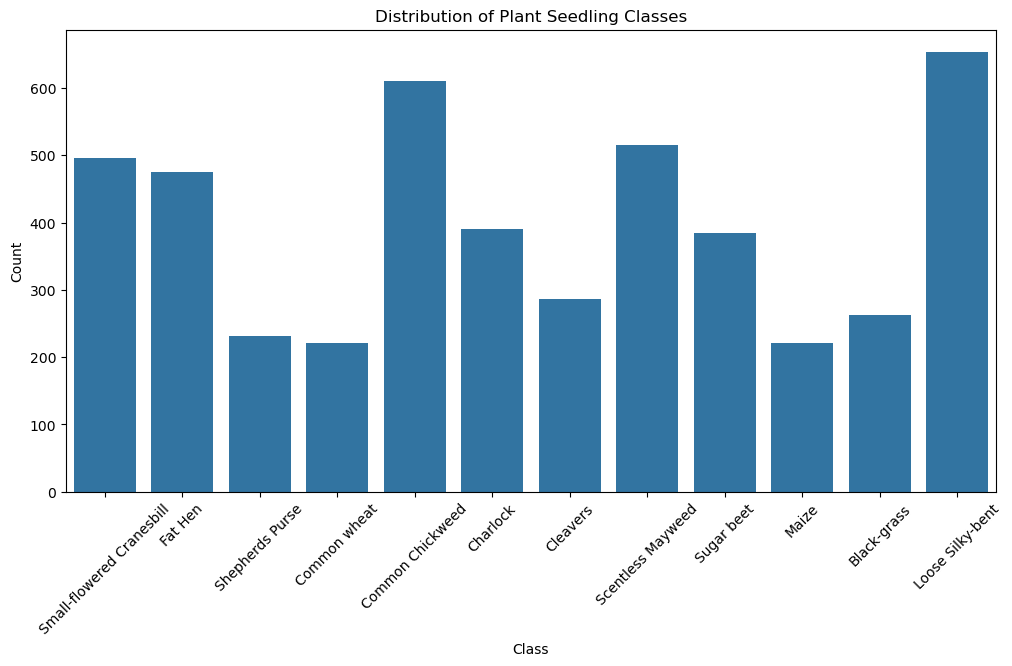

In [3]:
# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(x=labels['Label'], order=class_names)
plt.title('Distribution of Plant Seedling Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.savefig('class_distribution.png')
plt.show()

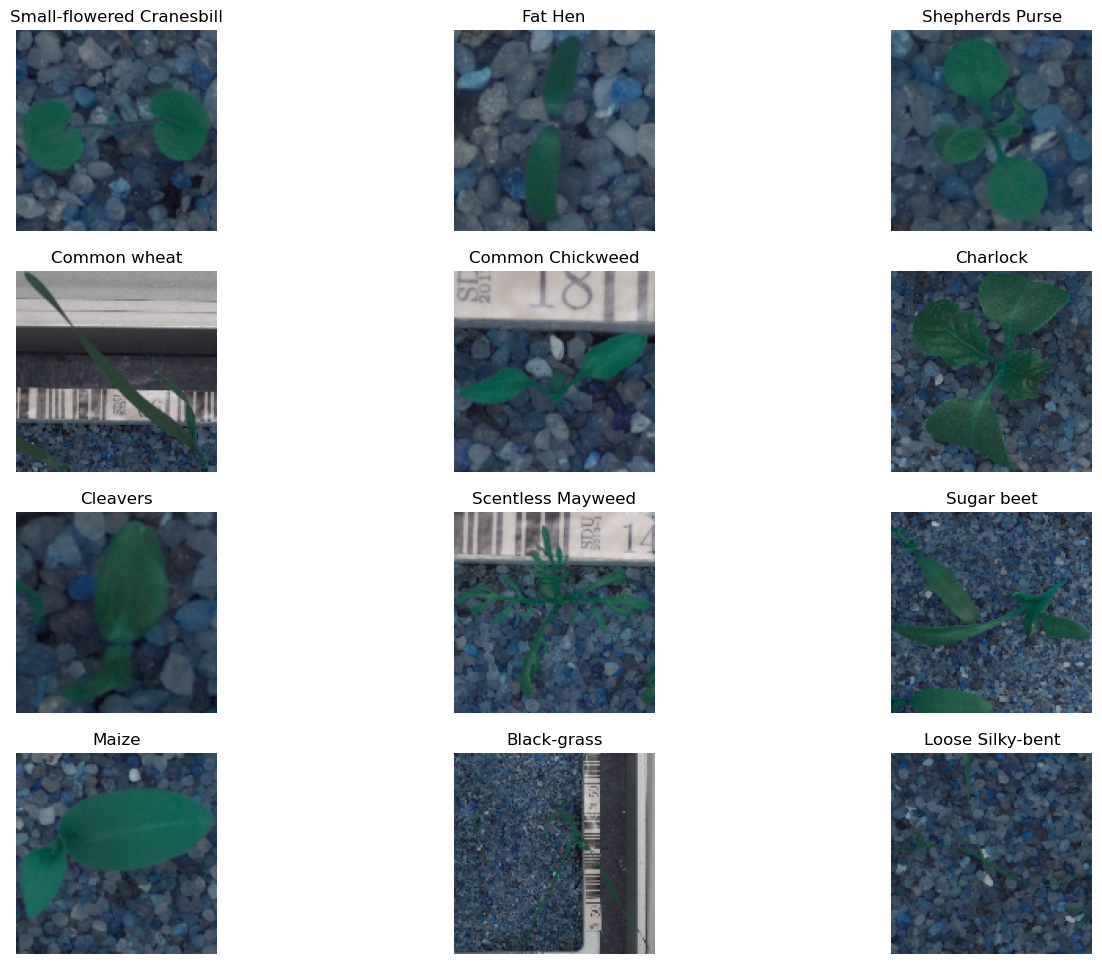

In [4]:
# Visualize sample images (all 12 classes)
plt.figure(figsize=(16, 12))
for i, label in enumerate(class_names):
    idx = labels[labels['Label'] == label].index[0]
    plt.subplot(4, 3, i+1)
    plt.imshow(images[idx])
    plt.title(label)
    plt.axis('off')
plt.savefig('sample_images.png')
plt.show()

In [5]:
# Downsample images to 64x64 and convert to float16
images_resized = tf.image.resize(images, [64, 64]).numpy()
images_resized = images_resized.astype('float16') / 255.0

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(images_resized, labels['Label'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_val_encoded = to_categorical(label_encoder.transform(y_val))
y_test_encoded = to_categorical(label_encoder.transform(y_test))

In [6]:
# Create tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)

In [7]:
# Save datasets
np.save('X_train.npy', X_train)
np.save('y_train_encoded.npy', y_train_encoded)
np.save('X_val.npy', X_val)
np.save('y_val_encoded.npy', y_val_encoded)
np.save('X_test.npy', X_test)
np.save('y_test_encoded.npy', y_test_encoded)

In [8]:
# Build and compile model
model = Sequential([
    Input(shape=(64, 64, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(12, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Generate and save model summary
model.summary()
with open('model_summary.txt', 'w', encoding='utf-8') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
# Take screenshot of model.summary() output from notebook for model_summary.png

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 684,748 (2.61 MB)

 Trainable params: 684,748 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=50,
                    callbacks=[early_stopping])

Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.1715 - loss: 2.3981 - val_accuracy: 0.4045 - val_loss: 1.8910
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.3416 - loss: 1.8871 - val_accuracy: 0.4607 - val_loss: 1.5709
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.4149 - loss: 1.6645 - val_accuracy: 0.5604 - val_loss: 1.2870
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.5092 - loss: 1.4077 - val_accuracy: 0.6222 - val_loss: 1.1329
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.5647 - loss: 1.2630 - val_accuracy: 0.6728 - val_loss: 0.9734
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.5971 - loss: 1.1590 - val_accuracy: 0.6138 - val_loss: 1.0688
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.6269 - loss: 1.0837 - val_accuracy: 0.7219 - val_loss: 0.8485
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.6734 - loss: 0.9561 - val_acc

In [11]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test accuracy: {test_accuracy}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7959 - loss: 0.6575
Test accuracy: 0.7868162989616394


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


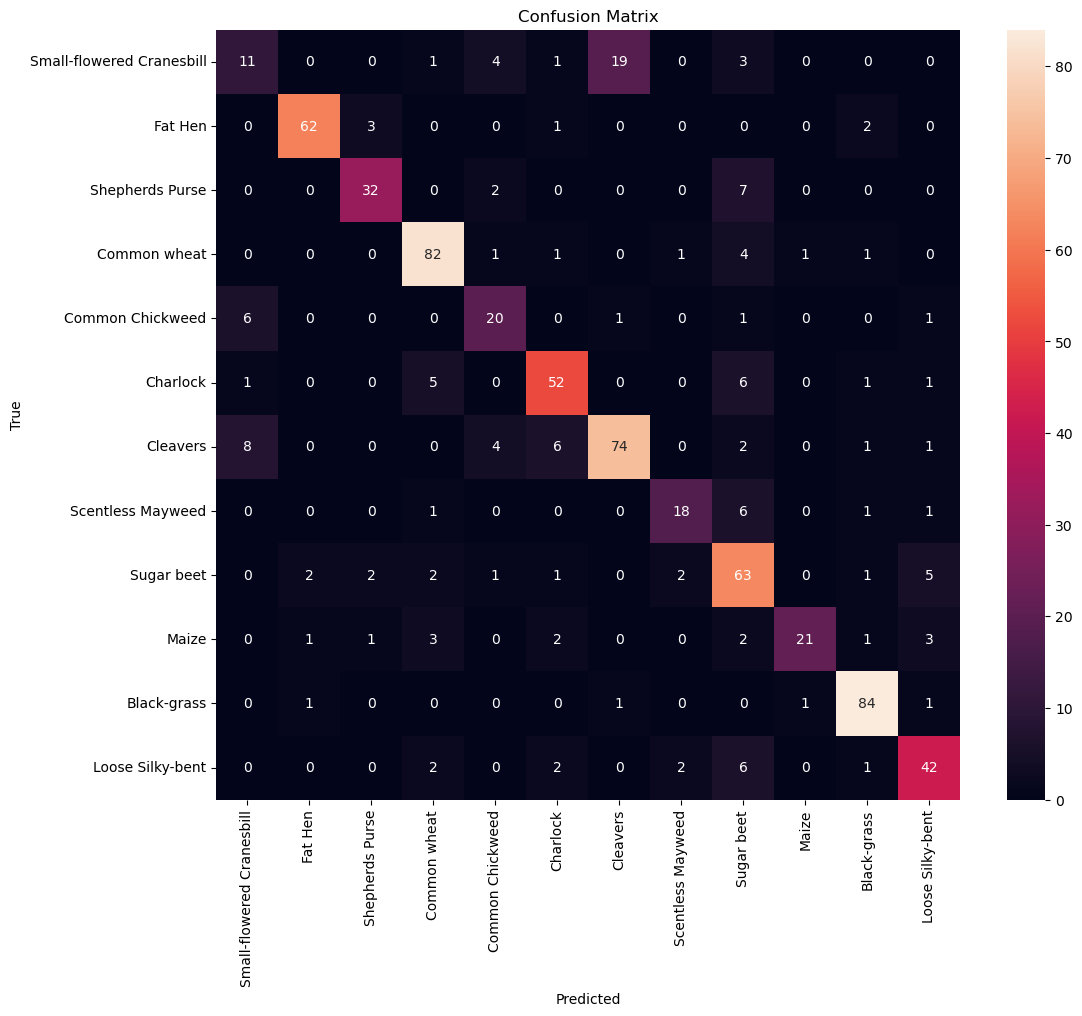

In [12]:
# Generate and save confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show()

In [13]:
# Generate and save classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
with open('classification_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)
print(report)  # Screenshot this output for classification_report.png

                           precision    recall  f1-score   support

Small-flowered Cranesbill       0.42      0.28      0.34        39
                  Fat Hen       0.94      0.91      0.93        68
          Shepherds Purse       0.84      0.78      0.81        41
             Common wheat       0.85      0.90      0.88        91
         Common Chickweed       0.62      0.69      0.66        29
                 Charlock       0.79      0.79      0.79        66
                 Cleavers       0.78      0.77      0.77        96
        Scentless Mayweed       0.78      0.67      0.72        27
               Sugar beet       0.63      0.80      0.70        79
                    Maize       0.91      0.62      0.74        34
              Black-grass       0.90      0.95      0.93        88
         Loose Silky-bent       0.76      0.76      0.76        55

                 accuracy                           0.79       713
                macro avg       0.77      0.74      0.75    

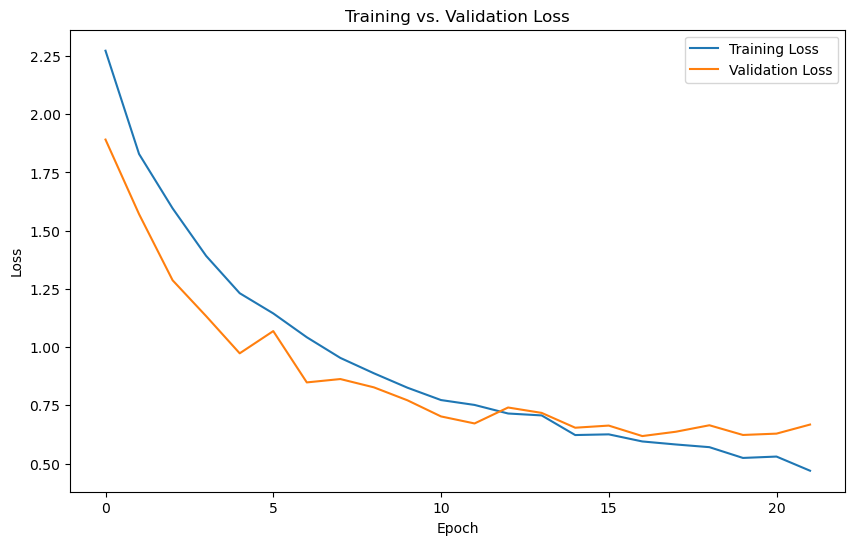

In [14]:
# Generate and save loss plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

In [15]:
# Save model
model.save('plant_seedling_cnn.keras')